In [3]:
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt 
import glob
import os
import xarray as xr 
import pandas as pd
import numpy as np


cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=48,                   # 24 cores per node
    processes=4,                # One process per task
    memory="400GB",             # --mem
    walltime="01:15:00",        # --time
    queue="med",                # --partition
    log_directory=".",          # Logs will be saved to the current directory
)

from dask.distributed import Client


cluster.scale(jobs=2)
client = Client(cluster)
client

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33591 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:33591/status,
Dashboard: http://10.42.239.61:33591/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:36593,Workers: 0
Dashboard: http://10.42.239.61:33591/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
client.close()
cluster.close()

In [4]:

filerh = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/Rh_mid/'

fileu = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/u_comp/'

filev = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/v_comp/'

file_sst_sp = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/surfacePT/'


In [3]:

def prepro(ds):
    ds_mean = ds.mean(dim='level')
    return ds_mean


dset_rh = xr.open_mfdataset(filerh+'*.nc',chunks={'time':1000},preprocess=prepro,parallel=True).sel(expver=1)#.compute()


In [3]:
dset_rh.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/RH_MID_2000_2023.nc')

In [9]:


def preprocess(uvdata):
    data = uvdata   
    meanup = data.sel(level=[200,250,300]).mean(dim='level')
    meanlow = data.sel(level=[775,800,925]).mean(dim='level')
    
    shear_c = abs(meanup - meanlow)
    
    return shear_c



dset_u = xr.open_mfdataset(fileu+'*.nc',chunks={'time':1000},preprocess=preprocess,parallel=True).sel(expver=1)
dset_v = xr.open_mfdataset(filev+'*.nc',chunks={'time':1000},preprocess=preprocess,parallel=True).sel(expver=1)



dset_shear = np.sqrt(dset_u['u']**2 + dset_v['v']**2)

dset_shear = dset_shear.to_dataset(name='shear')

dset_shear

<xarray.Dataset> Size: 37GB
Dimensions:    (longitude: 341, latitude: 193, time: 69594)
Coordinates:
  * longitude  (longitude) float32 1kB -83.0 -82.75 -82.5 ... 1.5 1.75 2.0
  * latitude   (latitude) float32 772B 43.0 42.75 42.5 42.25 ... -4.5 -4.75 -5.0
  * time       (time) datetime64[ns] 557kB 2000-01-01 ... 2023-10-26T03:00:00
    expver     int32 4B 1
Data variables:
    shear      (time, latitude, longitude) float64 37GB dask.array<chunksize=(966, 193, 341), meta=np.ndarray>

In [10]:
dset_shear.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/SHEAR_2000_2023.nc')

In [35]:
new_rh = xr.open_dataset('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/RH_MID_2000_2023.nc',chunks={'time':1000}).sel(time=slice('2000','2022'))

new_shear = xr.open_dataset('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/SHEAR_2000_2023.nc',chunks={'time':1000}).sel(time=slice('2000','2022'))

st_sst = xr.open_mfdataset(file_sst_sp+'*.nc',chunks={'time':1000},parallel=True).sel(expver=1)#.sel(time=slice('2000','2022'))

In [41]:
final_frame = new_rh.copy()

final_frame['shear'] = new_shear['shear'].reindex(time=new_rh['time'], method='nearest')
final_frame['sst'] = st_sst['sst'].reindex(time=new_rh['time'], method='nearest')
final_frame['sp'] = st_sst['sp'].reindex(time=new_rh['time'], method='nearest')

In [43]:
final_frame.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/RH_SST_SHEAR_SP_2000_2023.nc')

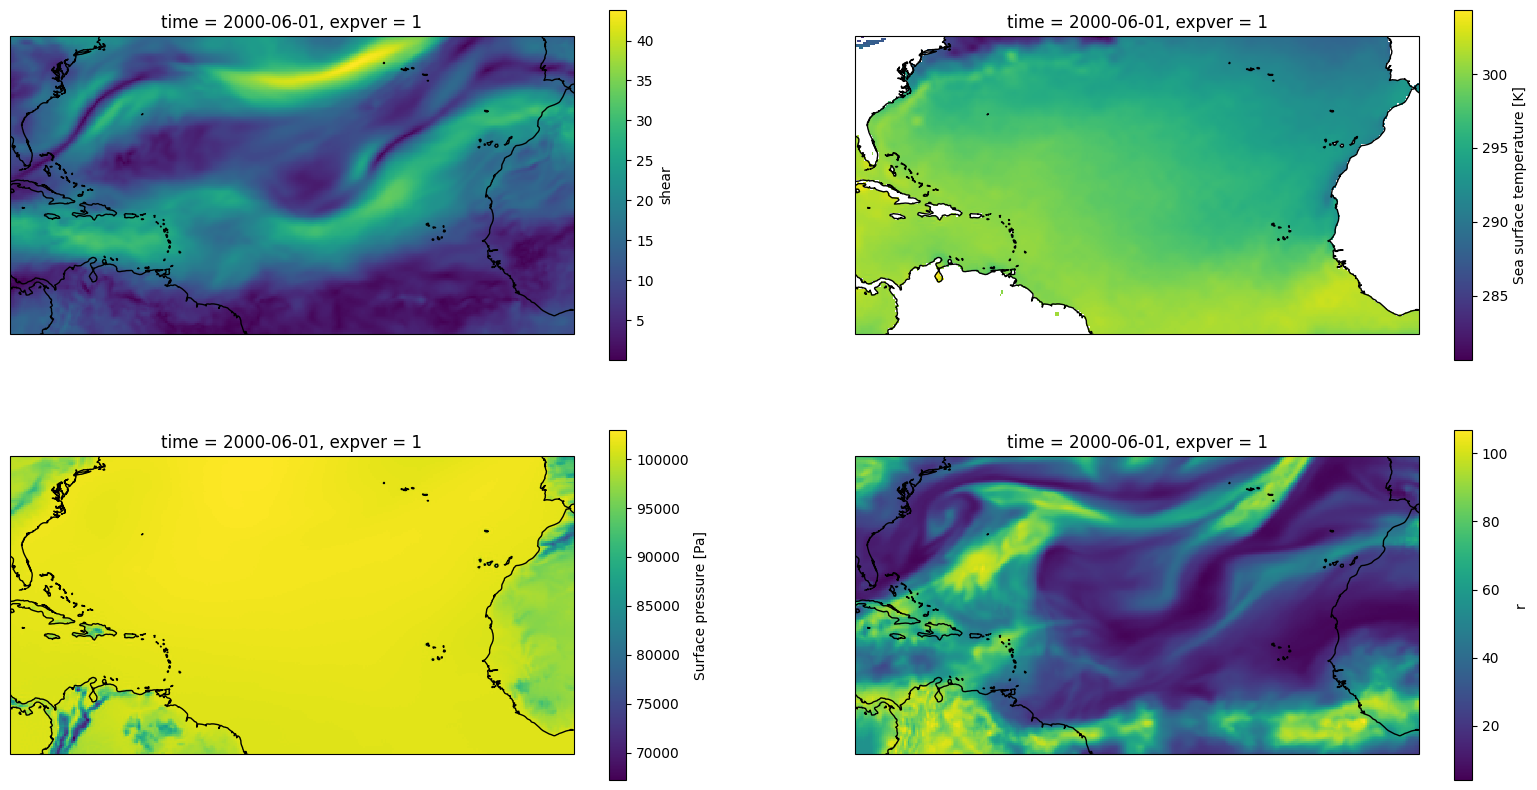

In [50]:
import cartopy.crs as ccrs

fig,ax = plt.subplots(2,2,figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})

final_frame['shear'].isel(time=0).plot(ax=ax[0,0],transform=ccrs.PlateCarree(),)
ax[0,0].coastlines()

final_frame['sst'].isel(time=0).plot(ax=ax[0,1],transform=ccrs.PlateCarree())

ax[0,1].coastlines()

final_frame['sp'].isel(time=0).plot(ax=ax[1,0],transform=ccrs.PlateCarree())

ax[1,0].coastlines()

final_frame['r'].isel(time=0).plot(ax=ax[1,1],transform=ccrs.PlateCarree())

ax[1,1].coastlines()

In [56]:

load_final_frame = xr.open_dataset('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/RH_SST_SHEAR_SP_2000_2023.nc',chunks={'time':1000})


coriolis_data  = cor_data =  2 * 7.29 * 1e-5 * np.sin(load_final_frame['latitude'])

n_data = np.repeat(coriolis_data.values[:,np.newaxis],len(load_final_frame['longitude']),axis=1)

n_data_time = np.repeat(n_data[np.newaxis],len(load_final_frame['time']),axis=0)


cor_dset = xr.DataArray(data=n_data_time,name='cor_parameter',
                        dims=['time','latitude','longitude'],
                        coords=dict(
                            latitude=(["latitude"], load_final_frame.latitude.values),
                            longitude=(["longitude"], load_final_frame.longitude.values),
                            time = (["time"], load_final_frame.time.values)))

In [60]:
load_final_frame['cor_parameter'] = cor_dset
load_final_frame['cor_parameter'].attrs['units'] = '1/s'

In [61]:
load_final_frame.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/RH_SST_SHEAR_SP_COR_2000_2023.nc')

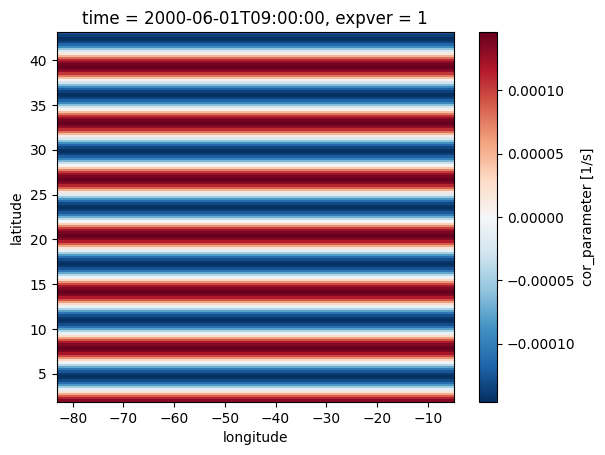

In [16]:
dset_speed.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/WIND_SPEED_2000_2023.nc')

NameError: name 'dset_speed' is not defined

In [37]:

dset_all = dset_u.copy()
dset_all['v'] = dset_v['v']
dset_all['rh'] = dset_rh['r']

dset_all['sp'] = dset_sst_sp['sp']
dset_all['sst'] = dset_sst_sp['sst']

In [38]:

dset_all['speed'] = np.sqrt(dset_all['u']**2 + dset_all['v']**2)

In [ ]:
dset_all = dset_all.persist()

<xarray.Dataset> Size: 769GB
Dimensions:    (longitude: 341, latitude: 193, level: 6, time: 69594)
Coordinates:
  * longitude  (longitude) float32 1kB -83.0 -82.75 -82.5 ... 1.5 1.75 2.0
  * latitude   (latitude) float32 772B 43.0 42.75 42.5 42.25 ... -4.5 -4.75 -5.0
  * level      (level) int32 24B 200 250 300 775 800 925
  * time       (time) datetime64[ns] 557kB 2000-01-01 ... 2023-10-26T03:00:00
    expver     int32 4B 1
Data variables:
    u          (time, level, latitude, longitude) float64 220GB dask.array<chunksize=(400, 6, 193, 341), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 220GB dask.array<chunksize=(397, 6, 193, 341), meta=np.ndarray>
    rh         (time, latitude, longitude) float64 37GB dask.array<chunksize=(737, 165, 313), meta=np.ndarray>
    sp         (time, latitude, longitude) float64 37GB dask.array<chunksize=(1444, 165, 313), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 37GB dask.array<chunksize=(1444, 165, 313), meta=np.ndarray>
    speed      (time, level, latitude, longitude) float64 220GB dask.array<chunksize=(397, 6, 193, 341), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-30 03:16:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [40]:
dset_all_new = dset_all.resample(time='6h').mean()

KeyboardInterrupt: 

In [37]:
dset_all_6h = dset_all.resample(time='6h').mean()

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


KeyboardInterrupt: 

In [32]:
dset_all['speed'] = np.sqrt(dset_all['u']**2 + dset_all['v']**2)


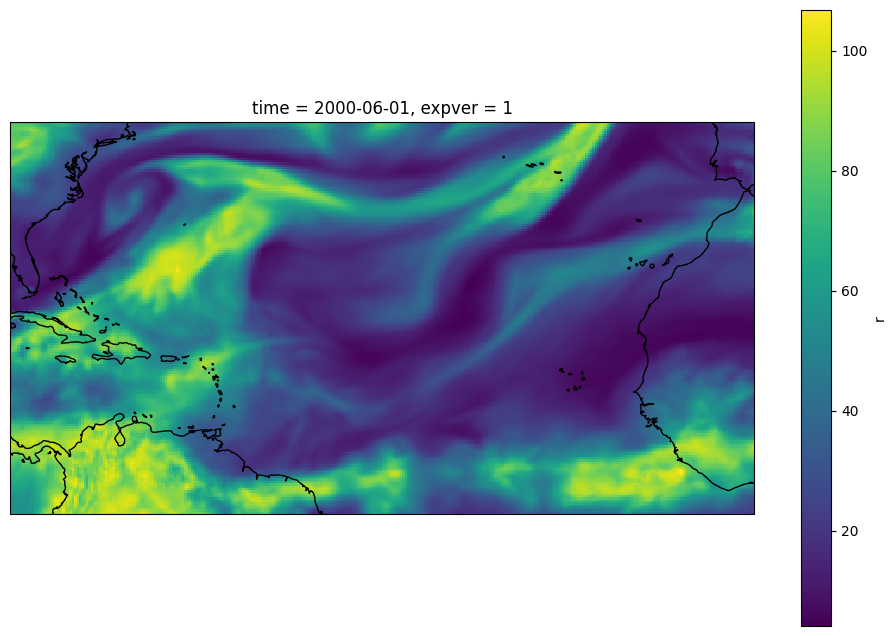

In [19]:
import cartopy.crs as ccrs

fig,ax = plt.subplots(figsize=(12, 8),subplot_kw={'projection': ccrs.PlateCarree()})
dset_rh.isel(time=0).r.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='viridis')

ax.coastlines()